In [1]:
# manipulacja danymi
import numpy as np
import pandas as pd

# wizualizacja
import matplotlib.pyplot as plt
import seaborn as sns

# podział danych na zbiory treningowe/walidacyjne/testowe
from sklearn.model_selection import train_test_split, GridSearchCV

# budowa Pipeline
from sklearn.pipeline import FeatureUnion, Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

# Preprocessing
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures, PowerTransformer

# redukcja wymiarowości
from sklearn.decomposition import PCA

# model
from sklearn.linear_model import LogisticRegression

# ewaluacja
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, f1_score, roc_auc_score

In [2]:
diabetes = pd.read_csv('diabetes.csv')
diabetes.head()

,PatientID,Pregnancies,PlasmaGlucose,DiastolicBloodPressure,TricepsThickness,SerumInsulin,BMI,DiabetesPedigree,Age,Diabetic
0,1354778,0,171,80,34,23,43.509726,1.213191,21,0
1,1147438,8,92,93,47,36,21.240576,0.158365,23,0
2,1640031,7,115,47,52,35,41.511523,0.079019,23,0
3,1883350,9,103,78,25,304,29.582192,1.282870,43,1
4,1424119,1,85,59,27,35,42.604536,0.549542,22,0


In [3]:
X = diabetes.drop(['Diabetic', 'PatientID', 'TricepsThickness'], axis=1).copy()
y = diabetes['Diabetic'].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

In [4]:
num_features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'SerumInsulin', 'BMI', 'Age']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('polynomial_features', PolynomialFeatures(degree=3)),
    ('scaler_1', StandardScaler()),
    ('pca', PCA(n_components=0.95)),
    ('scaler_2', StandardScaler())
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000, solver='saga'))])
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('polynomial_features',
                                                                   PolynomialFeatures(degree=3)),
                                                                  ('scaler_1',
                                                                   StandardScaler()),
                                                                  ('pca',
                                                                   PCA(n_components=0.95)),
                                                                  ('scaler_2',
                                                                   StandardScaler())]),
                                                  ['Pregnancies',
                                                   'PlasmaGlucose',
                                                   'DiastolicBloodPressu

In [5]:
scaler_2var = StandardScaler()
X_train_standardized = scaler_2var.fit_transform(X_train)
X_test_standardized = scaler_2var.transform(X_test)
model_lr = LogisticRegression()
model_lr.fit(X_train_standardized, y_train)

LogisticRegression()

In [6]:
metrics_dataframe = pd.DataFrame(columns = ['Model', 'F1_score', 'AUC'])
metrics_dataframe
models = []
models_names = []
predictions_proba_list = []

def calculate_metrics(model, name, X_checked, y_checked):
    models.append(model)
    models_names.append(name)
    global metrics_dataframe
    predictions = model.predict(X_checked)
    predictions_proba = model.predict_proba(X_checked)
    predictions_proba_list.append(predictions_proba[:,1])

    ############## metryki dla sprawdzanego modelu ################

    # Precision, Recall, F1, Accuracy
    print(classification_report(y_checked, predictions))

    # Confusion matrix
    plt.figure()
    cm = confusion_matrix(y_checked, predictions)
    ax = sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')
    ax.set_title('Confusion Matrix\n\n')
    ax.set_xlabel('\nPredicted Values')
    ax.set_ylabel('Actual Values ')
    plt.show()

    # plot ROC curve
    fig = plt.figure(figsize=(6, 6))
    plt.plot([0, 1], [0, 1], 'k--')
    for model_selected, name_selected, pred_proba in zip(models, models_names, predictions_proba_list):
        fpr, tpr, thresholds = roc_curve(y_checked, pred_proba)
        plt.plot(fpr, tpr, label=name_selected)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc='lower right')
    plt.show()

    f1_metric = f1_score(y_checked, predictions)
    auc_metric = roc_auc_score(y_checked, predictions_proba[:,1])
    metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},
                                                 ignore_index=True)
    return metrics_dataframe

In [7]:
num_features = ['Pregnancies', 'PlasmaGlucose', 'DiastolicBloodPressure', 'SerumInsulin', 'BMI', 'Age']

# przygotowanie wartości numerycznych
num_preparation = Pipeline(steps=[
    ('scaler_1', StandardScaler())
])

# transformer = wartości numeryczne oraz kategoryczne
data_preparation = ColumnTransformer(transformers=[
    ('numeric_preprocessing', num_preparation, num_features)
])

model_pipeline_v1 = Pipeline(steps=[('preprocessor', data_preparation),
                                    ('model', LogisticRegression(max_iter=10000, solver='saga'))])
model_pipeline_v1.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numeric_preprocessing',
                                                  Pipeline(steps=[('scaler_1',
                                                                   StandardScaler())]),
                                                  ['Pregnancies',
                                                   'PlasmaGlucose',
                                                   'DiastolicBloodPressure',
                                                   'SerumInsulin', 'BMI',
                                                   'Age'])])),
                ('model', LogisticRegression(max_iter=10000, solver='saga'))])

In [11]:
params = {
    'preprocessor__numeric_preprocessing__polynomial_features__degree': [1, 2, 3],
    'preprocessor__numeric_preprocessing__pca__n_components': [0.85, 0.90, 0.95, 0.99],
    'model__C': np.logspace(-4, 4, 50),
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__l1_ratio': [0, 0.5, 1]
}

grid_search = GridSearchCV(model_pipeline, params, cv=5, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_pipeline_v2 = grid_search.best_estimator_

Fitting 5 folds for each of 5400 candidates, totalling 27000 fits
Wybrane hiperparametry:  {'model__C': 0.18420699693267145, 'model__l1_ratio': 0, 'model__penalty': 'elasticnet', 'preprocessor__numeric_preprocessing__pca__n_components': 0.99, 'preprocessor__numeric_preprocessing__polynomial_features__degree': 2}


In [13]:
params = {
    'model__C': np.logspace(-4, 4, 50),
    'model__penalty': ['l1', 'l2', 'elasticnet'],
    'model__l1_ratio': [0, 0.5, 1]
}

grid_search = GridSearchCV(model_pipeline_v1, params, cv=5, n_jobs=-1, verbose=10, scoring='f1_macro')
grid_search.fit(X_train, y_train)
print('Wybrane hiperparametry: ', grid_search.best_params_)
model_pipeline_v3 = grid_search.best_estimator_

Fitting 5 folds for each of 450 candidates, totalling 2250 fits
Wybrane hiperparametry:  {'model__C': 1.2067926406393288, 'model__l1_ratio': 0, 'model__penalty': 'elasticnet'}


              precision    recall  f1-score   support

           0       0.79      0.90      0.84      2500
           1       0.72      0.53      0.61      1250

    accuracy                           0.77      3750
   macro avg       0.76      0.71      0.73      3750
weighted avg       0.77      0.77      0.76      3750



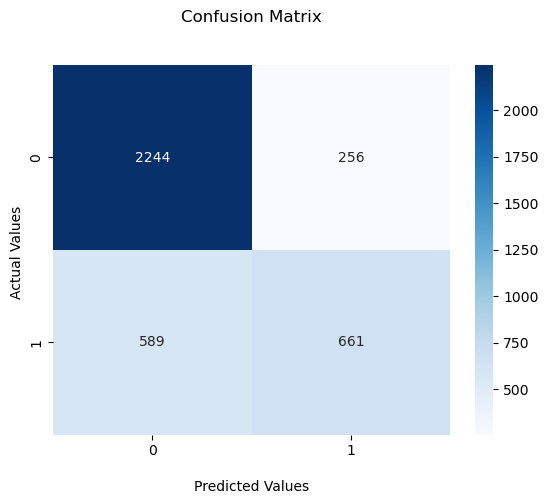

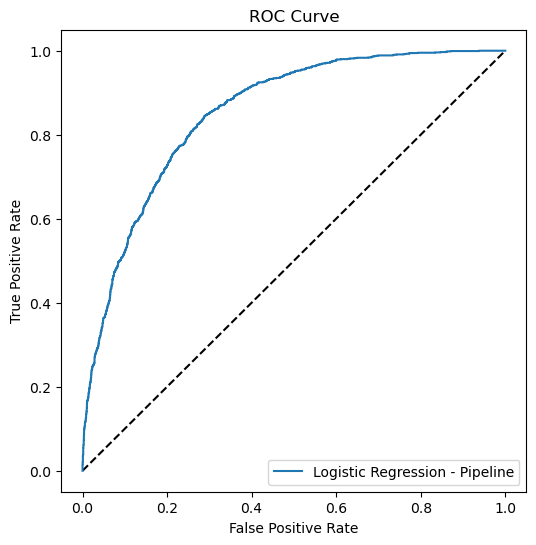

              precision    recall  f1-score   support

           0       0.81      0.88      0.84      2500
           1       0.70      0.58      0.64      1250

    accuracy                           0.78      3750
   macro avg       0.76      0.73      0.74      3750
weighted avg       0.77      0.78      0.77      3750



C:\Users\Admin\AppData\Local\Temp\ipykernel_21452\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


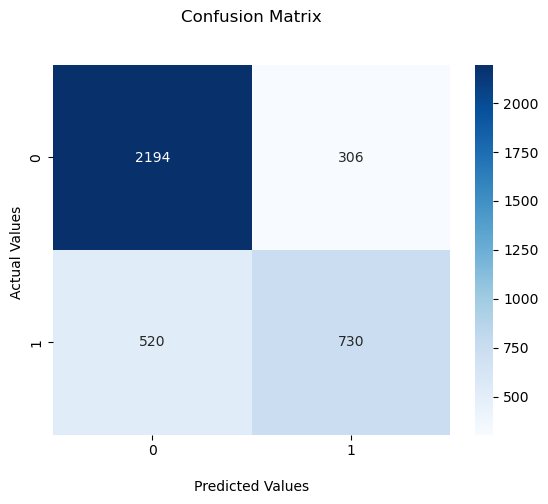

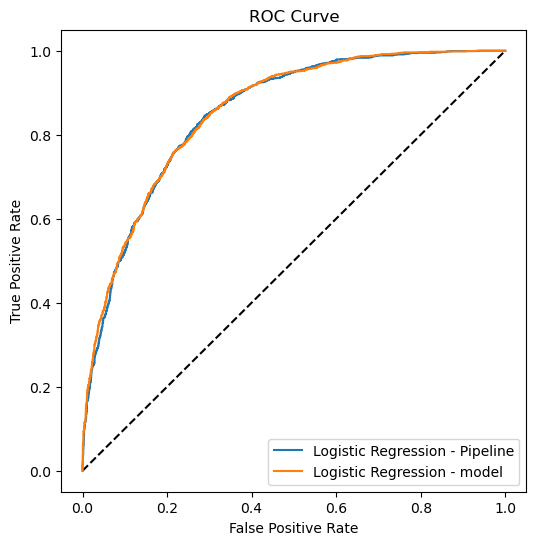

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2500
           1       0.70      0.57      0.62      1250

    accuracy                           0.77      3750
   macro avg       0.75      0.72      0.73      3750
weighted avg       0.77      0.77      0.77      3750



C:\Users\Admin\AppData\Local\Temp\ipykernel_21452\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


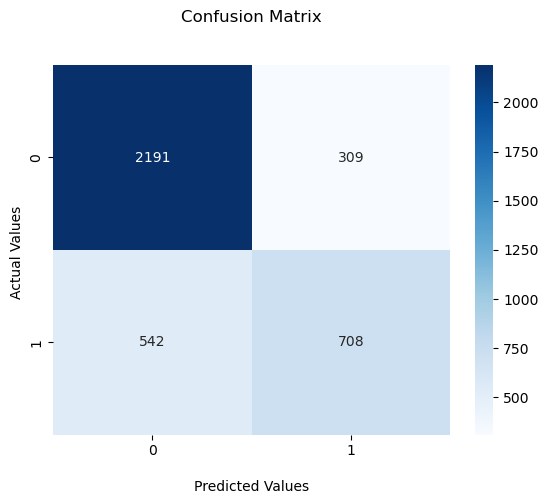

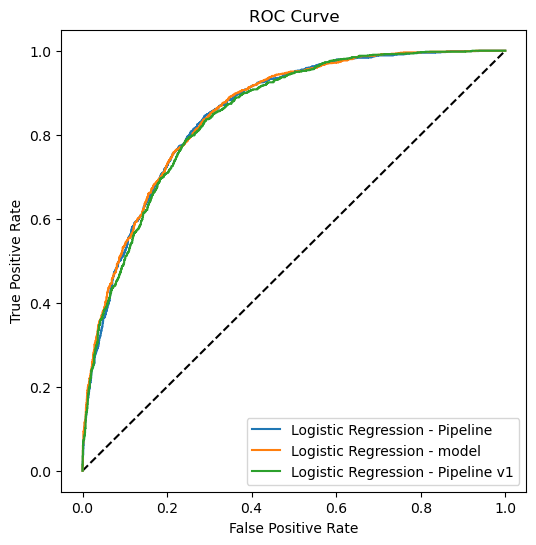

              precision    recall  f1-score   support

           0       0.83      0.89      0.86      2500
           1       0.74      0.65      0.69      1250

    accuracy                           0.81      3750
   macro avg       0.79      0.77      0.77      3750
weighted avg       0.80      0.81      0.80      3750



C:\Users\Admin\AppData\Local\Temp\ipykernel_21452\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


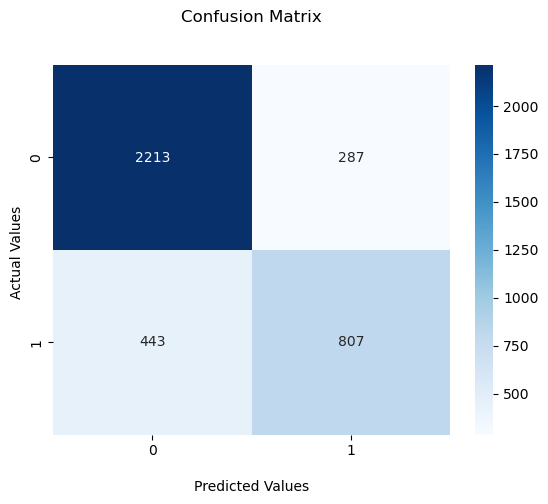

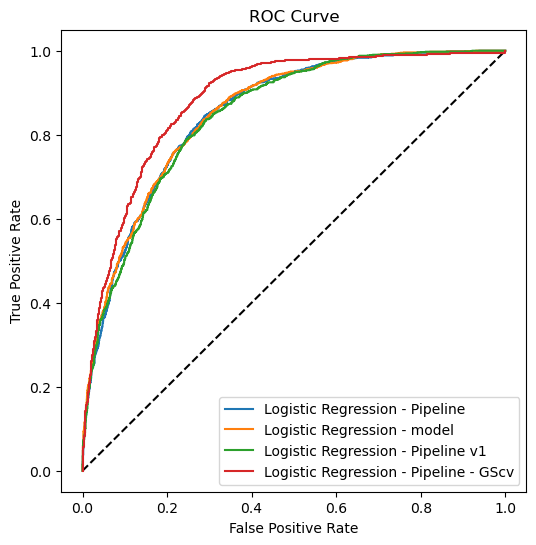

              precision    recall  f1-score   support

           0       0.80      0.88      0.84      2500
           1       0.70      0.57      0.62      1250

    accuracy                           0.77      3750
   macro avg       0.75      0.72      0.73      3750
weighted avg       0.77      0.77      0.77      3750



C:\Users\Admin\AppData\Local\Temp\ipykernel_21452\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


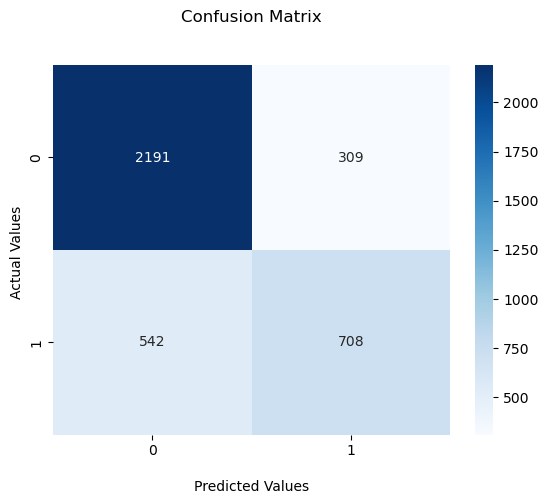

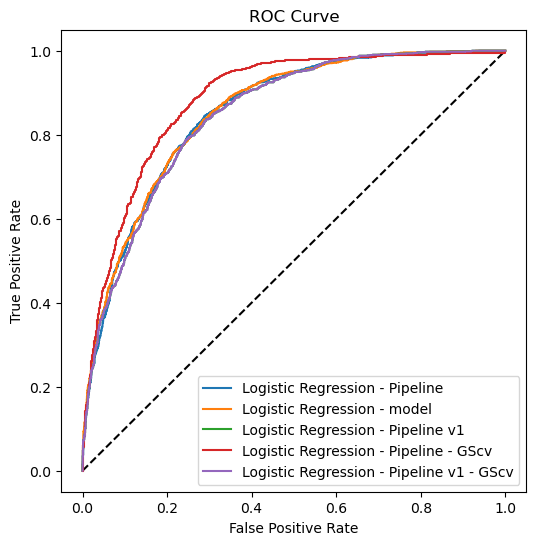

C:\Users\Admin\AppData\Local\Temp\ipykernel_21452\2055394858.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  metrics_dataframe = metrics_dataframe.append({'Model': name, 'F1_score': f1_metric, 'AUC': auc_metric},


,Model,F1_score,AUC
0,Logistic Regression - Pipeline,0.610060,0.852277
1,Logistic Regression - model,0.638670,0.854604
2,Logistic Regression - Pipeline v1,0.624614,0.847912
3,Logistic Regression - Pipeline - GScv,0.688567,0.884160
4,Logistic Regression - Pipeline v1 - GScv,0.624614,0.847912


In [14]:
calculate_metrics(model_pipeline, 'Logistic Regression - Pipeline', X_test, y_test)
calculate_metrics(model_lr, 'Logistic Regression - model', X_test_standardized, y_test)
calculate_metrics(model_pipeline_v1, 'Logistic Regression - Pipeline v1', X_test, y_test)
calculate_metrics(model_pipeline_v2, 'Logistic Regression - Pipeline - GScv', X_test, y_test)
calculate_metrics(model_pipeline_v3, 'Logistic Regression - Pipeline v1 - GScv', X_test, y_test)

### Super, teraz widzę potęgę GridSearchCV. Prawie 90% separacji i 7% zmiany w precyzji/czułości. Czy można coś jeszcze zrobić by zwiększyć True Positive rate w stosunku do False Positive rate?